In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Inputs

In [2]:
flow= pd.read_csv('../../model/model_versions/v_7/v_7_1/0058363.txt', index_col=0, sep='\t')
flow = flow.iloc[1:]  # Drop the first row

### Define Functions

In [3]:
def compute_kge(simulated_array, observed_array):
    """
    Computes KGE (Kling-Gupta Efficiency) between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: KGE value.
    """
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(observed_array, simulated_array)[0, 1]
    
    # Calculate standard deviation ratio
    std_observed = np.std(observed_array)
    std_simulated = np.std(simulated_array)
    std_ratio = std_simulated / std_observed
    
    # Calculate bias ratio
    mean_observed = np.mean(observed_array)
    mean_simulated = np.mean(simulated_array)
    bias_ratio = mean_simulated / mean_observed
    
    # Calculate KGE
    kge = 1 - np.sqrt((correlation_coefficient - 1)**2 + (std_ratio - 1)**2 + (bias_ratio - 1)**2)
    
    return kge

In [4]:
def compute_nse(simulated_array, observed_array):
    """
    Computes NSE (Nash-Sutcliffe Efficiency) between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: NSE value.
    """
    
    # Calculate the mean of the observed data
    mean_observed = np.mean(observed_array)
    
    # Calculate the numerator (sum of squared differences between observed and simulated)
    numerator = np.sum((observed_array - simulated_array) ** 2)
    
    # Calculate the denominator (sum of squared differences between observed and mean observed)
    denominator = np.sum((observed_array - mean_observed) ** 2)
    
    # Calculate NSE
    nse = 1 - (numerator / denominator)
    
    return nse

In [5]:
# Define the compute_lognse function
def compute_lognse(simulated_array, observed_array):
    """
    Computes log-transformed NSE (Nash-Sutcliffe Efficiency) between observed and simulated values.
    """
    # Handle potential zero or negative values in the observed array
    observed_array = np.clip(observed_array, 1e-10, None)  # Avoid log(0) or log(negative)
    simulated_array = np.clip(simulated_array, 1e-10, None)
    
    # Calculate the mean of the logged observed data
    mean_observed = np.mean(np.log(observed_array))
    
    # Calculate the numerator (sum of squared differences between logged observed and simulated)
    numerator = np.sum((np.log(observed_array) - np.log(simulated_array)) ** 2)
    
    # Calculate the denominator (sum of squared differences between logged observed and mean logged observed)
    denominator = np.sum((np.log(observed_array) - mean_observed) ** 2)
    
    # Calculate log-transformed NSE
    lognse = 1 - (numerator / denominator)
    
    return lognse

In [6]:
def calculate_metrics_for_group(group):
    # Ensure 'cout' and 'rout' are numeric
    group['cout'] = pd.to_numeric(group['cout'], errors='coerce')
    group['rout'] = pd.to_numeric(group['rout'], errors='coerce')
    
    # Return NaN if the group has 3 values or fewer
    if len(group) <= 3:
        return pd.Series({
            'KGE': np.nan,
            'NSE': np.nan,
            'logNSE': np.nan,
            'first_date': group.index.min(),
            'last_date': group.index.max()
        })

    # Calculate KGE, NSE, and log-transformed NSE
    kge_value = compute_kge(group['cout'].values, group['rout'].values)
    nse_value = compute_nse(group['cout'].values, group['rout'].values)
    lognse_value = compute_lognse(group['cout'].values, group['rout'].values)
    
    # Get the date range for the group
    first_date = group.index.min()
    last_date = group.index.max()
    
    return pd.Series({
        'KGE': kge_value,
        'NSE': nse_value,
        'logNSE': lognse_value,
        'first_date': first_date,
        'last_date': last_date
    })

### Formatting

In [7]:
# Convert the index to a DatetimeIndex
flow.index = pd.to_datetime(flow.index)

In [8]:
# Convert all columns to numeric
flow = flow.apply(pd.to_numeric, errors='coerce')

In [9]:
# Assuming flow is your DataFrame
flow.replace(-9999.0, np.nan, inplace=True)

In [10]:
# Create a boolean mask for the date range
mask = ((flow.index.month > 4) & (flow.index.month < 11)) | \
       ((flow.index.month == 4) & (flow.index.day >= 1)) | \
       ((flow.index.month == 11) & (flow.index.day <= 7))

# Apply the mask to the DataFrame
filtered_flow = flow[mask]

In [11]:
# Convert the index to a DatetimeIndex
filtered_flow.index = pd.to_datetime(filtered_flow.index)

Find Average Annual df

In [12]:
# Prepare average annual weekly dataframe
# Reset index to have 'DATE' as a column
filtered_flow = filtered_flow.reset_index()
filtered_flow.rename(columns={'index': 'DATE'}, inplace=True)

# Extract month-day and add as a new column
filtered_flow['month_day'] = filtered_flow['DATE'].dt.strftime('%m-%d')

# Group by 'month_day' and calculate the average for each column
average_annual_values = filtered_flow.groupby('month_day').mean(numeric_only=True)

In [13]:
# Reset weekly flow dataframe
# Set DATE as the index
filtered_flow.set_index('DATE', inplace=True)

# Drop the month_day column
filtered_flow.drop(columns='month_day', inplace=True)

Add Label for each Day, Month and Year

In [14]:
# Create the 'week' column, starting from 1 and incrementing every 7 rows
filtered_flow['week'] = (np.floor(np.arange(len(filtered_flow)) / 7) + 1).astype(int)
average_annual_values['week'] = (np.floor(np.arange(len(average_annual_values)) / 7) + 1).astype(int)

In [15]:
# Extract year and month and create a unique identifier for each month
filtered_flow['year_month'] = filtered_flow.index.to_period('M')

In [16]:
# Create a mapping from year_month to incremental month number
month_mapping = {period: idx + 1 for idx, period in enumerate(sorted(filtered_flow['year_month'].unique()))}
filtered_flow['month'] = filtered_flow['year_month'].map(month_mapping)

In [17]:
# Extract year from the index
filtered_flow['year'] = filtered_flow.index.year

# Create a 'year_increment' column where each time the year increases, it adds 1
#filtered_flow['year'] = filtered_flow['year'].rank(method='dense').astype(int)

### Weekly

Calculates for each week in the timeseries and for each week in the average annual timeseries

In [18]:
# Calculate Metrics for Weekly
weekly_metrics = filtered_flow.groupby('week').apply(calculate_metrics_for_group).reset_index()

# Optionally, set 'week' as the index
weekly_metrics.set_index('week', inplace=True)

# Convert index to integer if it's not already (for better x-axis labeling)
weekly_metrics.index = weekly_metrics.index.astype(int)

C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  std_ratio = std_simulated / std_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  bias_ratio = mean_simulated / mean_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\3772300535.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  nse = 1 - (numerator / denominator)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[

In [19]:
# Calculate Metrics for Average Annual
average_annual_metrics = average_annual_values.groupby('week').apply(calculate_metrics_for_group).reset_index()

# Optionally, set 'week' as the index
average_annual_metrics.set_index('week', inplace=True)

# Convert index to integer if it's not already (for better x-axis labeling)
average_annual_metrics.index = average_annual_metrics.index.astype(int)

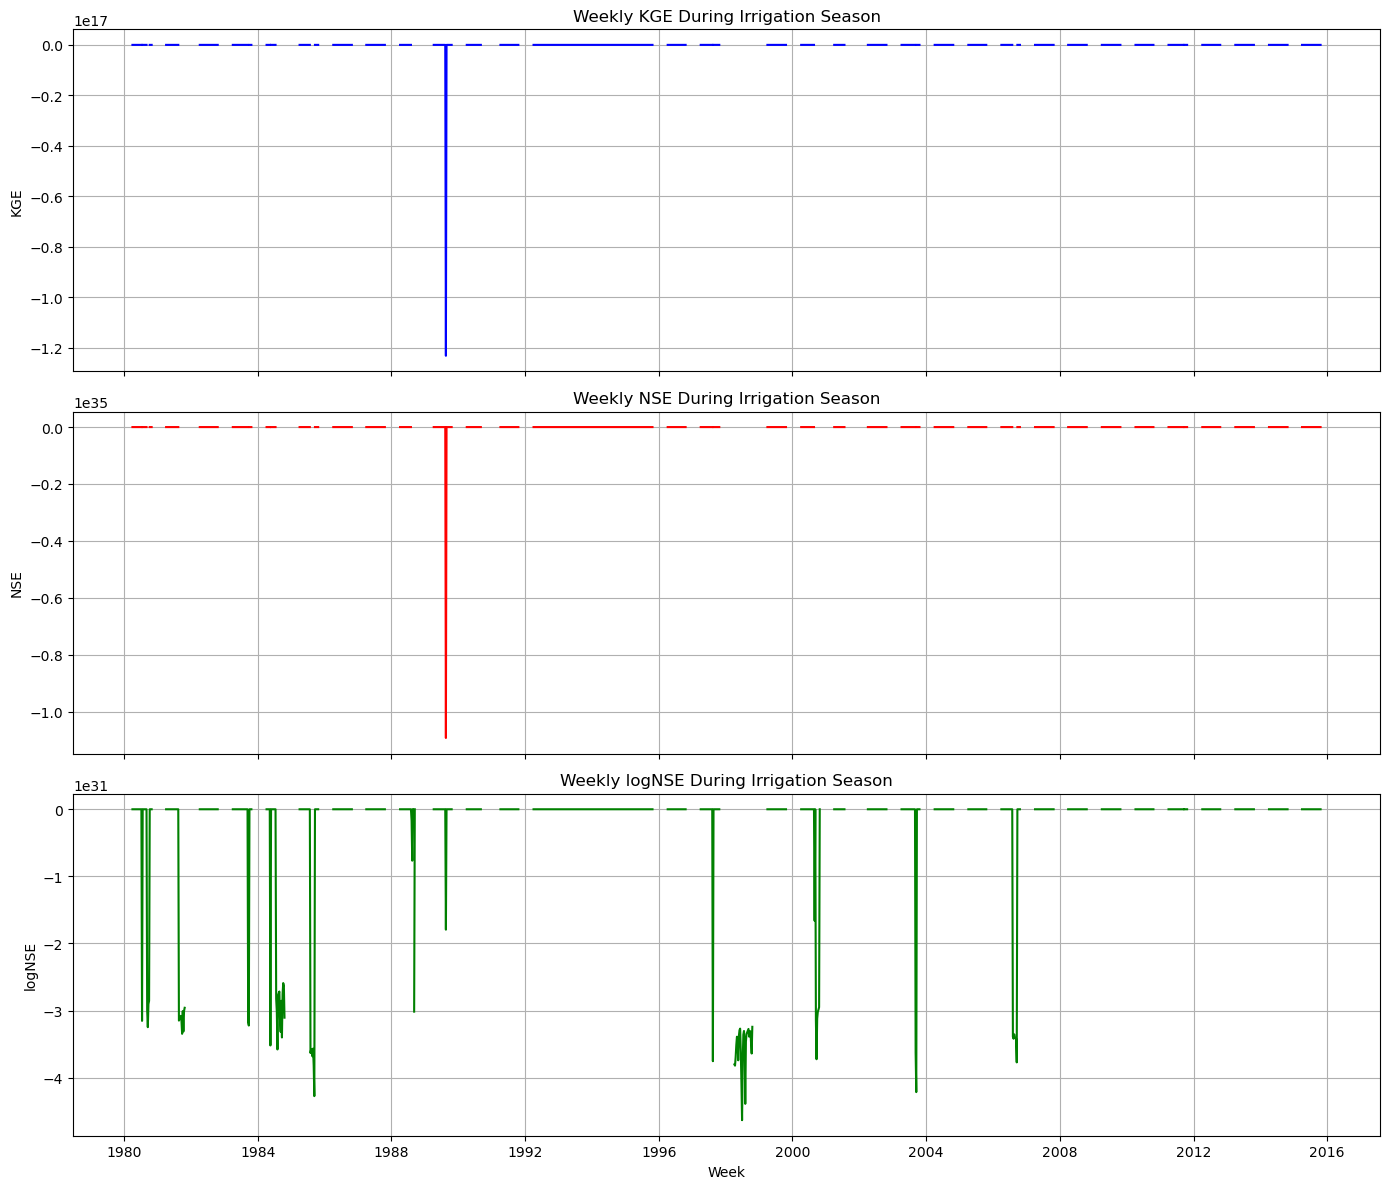

In [20]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot KGE
axs[0].plot(weekly_metrics['first_date'], weekly_metrics['KGE'], linestyle='-', color='b')
axs[0].set_title('Weekly KGE During Irrigation Season')
axs[0].set_ylabel('KGE')
axs[0].grid(True)

# Plot NSE
axs[1].plot(weekly_metrics['first_date'], weekly_metrics['NSE'],  linestyle='-', color='r')
axs[1].set_title('Weekly NSE During Irrigation Season')
axs[1].set_ylabel('NSE')
axs[1].grid(True)

# Plot logNSE
axs[2].plot(weekly_metrics['first_date'], weekly_metrics['logNSE'],  linestyle='-', color='g')
axs[2].set_title('Weekly logNSE During Irrigation Season')
axs[2].set_ylabel('logNSE')
axs[2].set_xlabel('Week')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

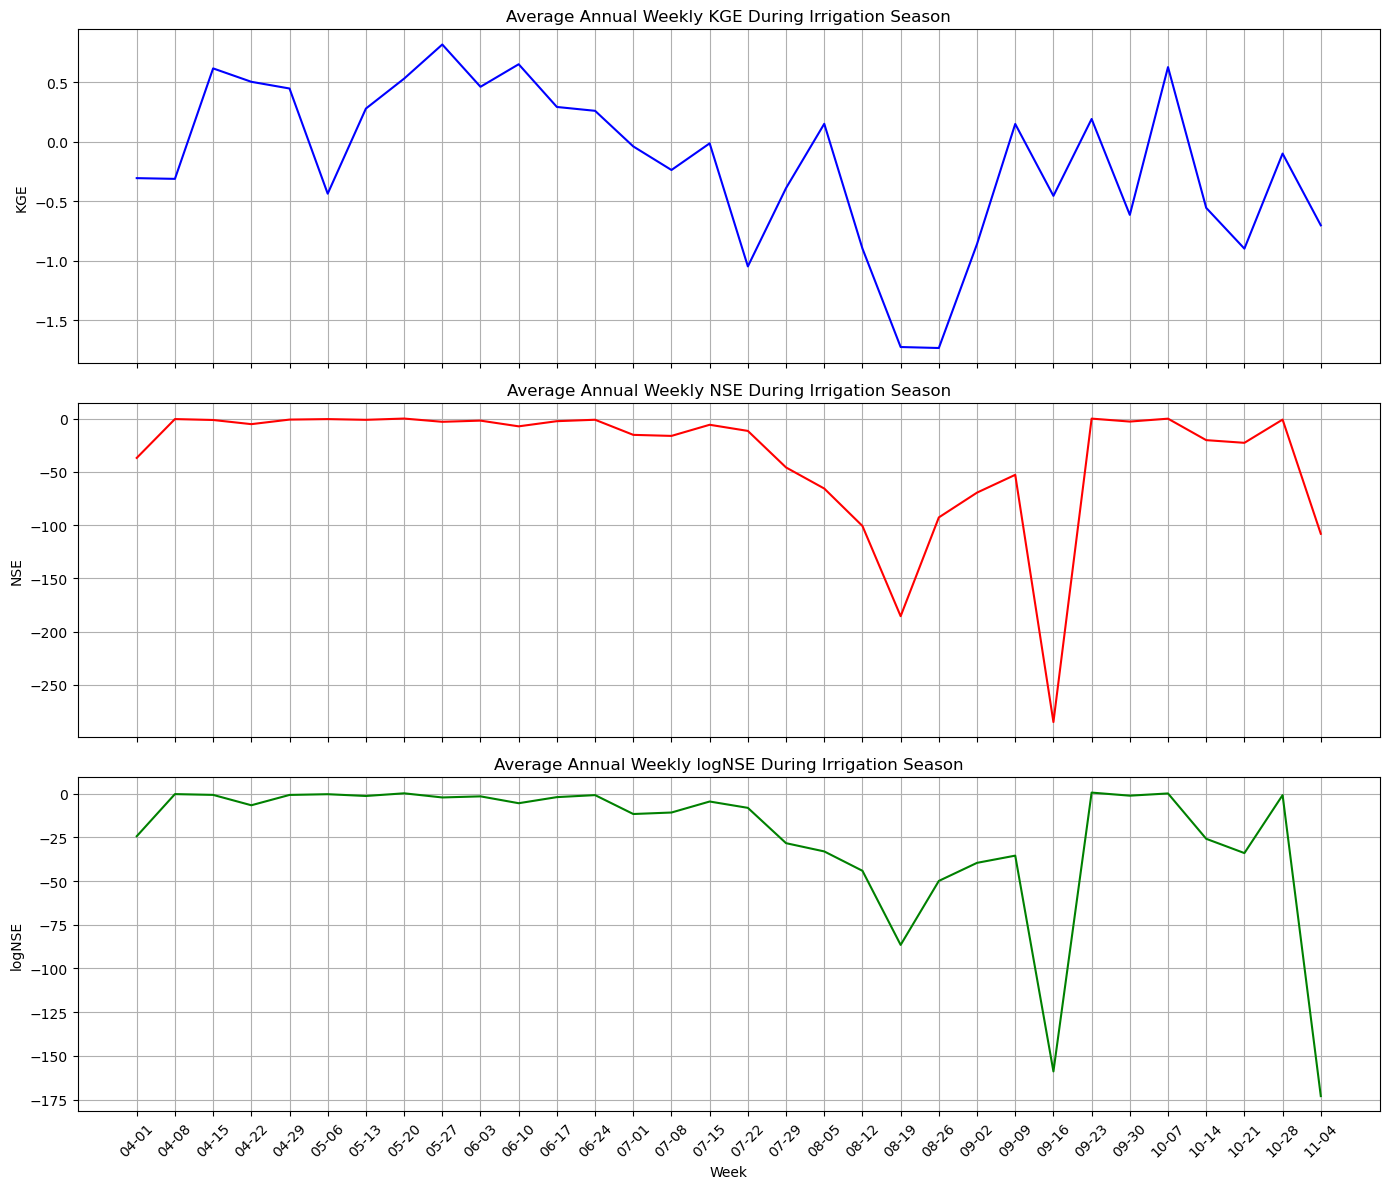

In [21]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot KGE
axs[0].plot(average_annual_metrics['first_date'], average_annual_metrics['KGE'], linestyle='-', color='b')
axs[0].set_title('Average Annual Weekly KGE During Irrigation Season')
axs[0].set_ylabel('KGE')
axs[0].grid(True)

# Plot NSE
axs[1].plot(average_annual_metrics['first_date'], average_annual_metrics['NSE'],  linestyle='-', color='r')
axs[1].set_title('Average Annual Weekly NSE During Irrigation Season')
axs[1].set_ylabel('NSE')
axs[1].grid(True)

# Plot logNSE
axs[2].plot(average_annual_metrics['first_date'], average_annual_metrics['logNSE'],  linestyle='-', color='g')
axs[2].set_title('Average Annual Weekly logNSE During Irrigation Season')
axs[2].set_ylabel('logNSE')
axs[2].set_xlabel('Week')
axs[2].grid(True)

# Tilt x-axis labels to 45 degrees
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Monthly

Currently only calculates metrics for each month in the timeseries

In [22]:
# Calculate Metrics for Weekly
monthly_metrics = filtered_flow.groupby('month').apply(calculate_metrics_for_group).reset_index()

# Optionally, set 'week' as the index
monthly_metrics.set_index('month', inplace=True)

# Convert index to integer if it's not already (for better x-axis labeling)
monthly_metrics.index = monthly_metrics.index.astype(int)

C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  std_ratio = std_simulated / std_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  bias_ratio = mean_simulated / mean_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\3772300535.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  nse = 1 - (numerator / denominator)
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[

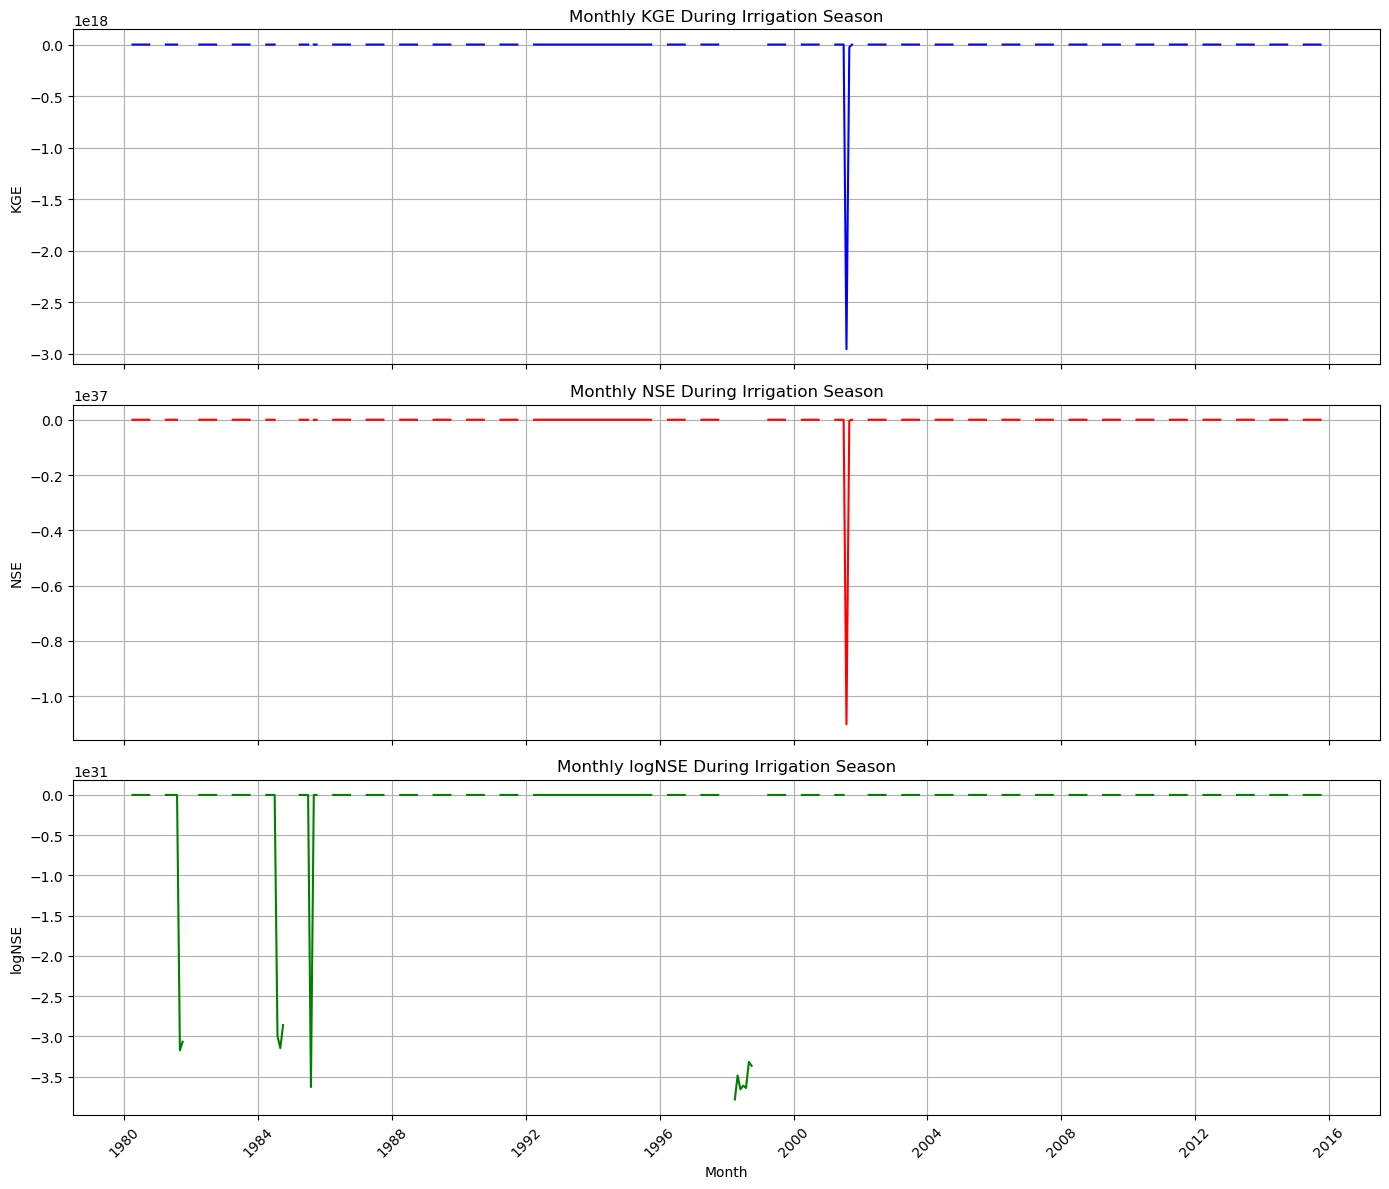

In [23]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot KGE
axs[0].plot(monthly_metrics['first_date'], monthly_metrics['KGE'], linestyle='-', color='b')
axs[0].set_title('Monthly KGE During Irrigation Season')
axs[0].set_ylabel('KGE')
axs[0].grid(True)

# Plot NSE
axs[1].plot(monthly_metrics['first_date'], monthly_metrics['NSE'],  linestyle='-', color='r')
axs[1].set_title('Monthly NSE During Irrigation Season')
axs[1].set_ylabel('NSE')
axs[1].grid(True)

# Plot logNSE
axs[2].plot(monthly_metrics['first_date'], monthly_metrics['logNSE'],  linestyle='-', color='g')
axs[2].set_title('Monthly logNSE During Irrigation Season')
axs[2].set_ylabel('logNSE')
axs[2].set_xlabel('Month')
axs[2].grid(True)

# Tilt x-axis labels to 45 degrees
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Annual

In [24]:
filtered_flow

,cout,rout,fcon,week,year_month,month,year
DATE,,,,,,,
1980-04-01,3.028,0.701,1.000,1,1980-04,1,1980
1980-04-02,4.951,0.892,1.000,1,1980-04,1,1980
1980-04-03,5.015,0.828,1.000,1,1980-04,1,1980
1980-04-04,4.021,0.605,1.000,1,1980-04,1,1980
1980-04-05,4.689,0.841,0.989,1,1980-04,1,1980
...,...,...,...,...,...,...,...
2015-11-03,0.041,NaN,0.091,1136,2015-11,288,2015
2015-11-04,0.052,NaN,0.095,1137,2015-11,288,2015
2015-11-05,0.055,NaN,0.095,1137,2015-11,288,2015


In [25]:
# Convert 'cout' and 'rout' columns to numeric
filtered_flow['cout'] = pd.to_numeric(filtered_flow['cout'], errors='coerce')
filtered_flow['rout'] = pd.to_numeric(filtered_flow['rout'], errors='coerce')

In [26]:
annual_metrics= filtered_flow.copy()

# remove nan rows for annual
annual_metrics = annual_metrics.dropna()

In [27]:
# Calculate Metrics for Weekly
seasonal_metrics = annual_metrics.groupby('year').apply(calculate_metrics_for_group).reset_index()

# Optionally, set 'week' as the index
seasonal_metrics.set_index('year', inplace=True)

# Convert index to integer if it's not already (for better x-axis labeling)
seasonal_metrics.index = seasonal_metrics.index.astype(int)

C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Paul Coderre\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  std_ratio = std_simulated / std_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\2361968326.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  bias_ratio = mean_simulated / mean_observed
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\3772300535.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  nse = 1 - (numerator / denominator)
C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_40308\1497975256.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  lognse = 1 

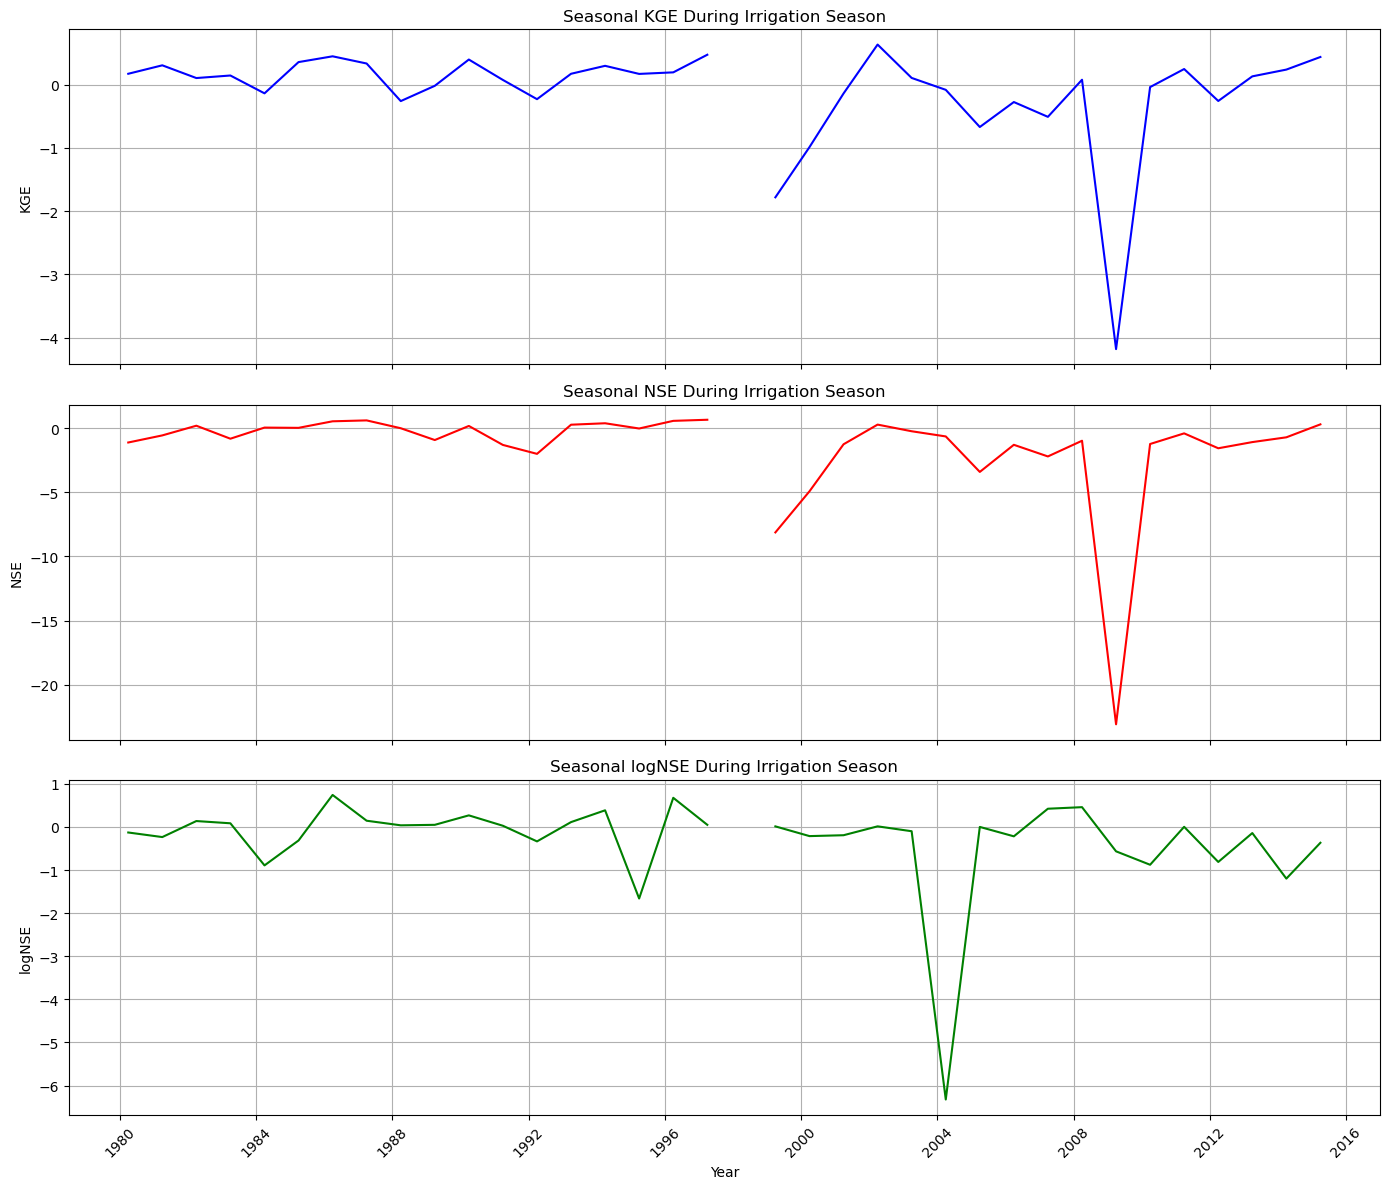

In [28]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot KGE
axs[0].plot(seasonal_metrics['first_date'], seasonal_metrics['KGE'], linestyle='-', color='b')
axs[0].set_title('Seasonal KGE During Irrigation Season')
axs[0].set_ylabel('KGE')
axs[0].grid(True)

# Plot NSE
axs[1].plot(seasonal_metrics['first_date'], seasonal_metrics['NSE'],  linestyle='-', color='r')
axs[1].set_title('Seasonal NSE During Irrigation Season')
axs[1].set_ylabel('NSE')
axs[1].grid(True)

# Plot logNSE
axs[2].plot(seasonal_metrics['first_date'], seasonal_metrics['logNSE'],  linestyle='-', color='g')
axs[2].set_title('Seasonal logNSE During Irrigation Season')
axs[2].set_ylabel('logNSE')
axs[2].set_xlabel('Year')
axs[2].grid(True)

# Tilt x-axis labels to 45 degrees
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()